# Assignment: Implementing MADDPG with the TorchRL Toolkit
In this task, you’ll implement the MADDPG algorithm — a method used to train multiple agents to learn and collaborate effectively.

To make things smoother, we’ll be using TorchRL, a library that simplifies building and training RL agents.

The assignment has two main goals:

1. Help you understand the key ideas behind MADDPG, especially the idea of centralized training (agents learn together) and decentralized execution (they act independently).

2. Introduce you to important TorchRL.

We’ve already set up the basic structure for you. Your job is to complete the missing pieces marked as TODOs. Before each coding step, we’ll explain what the MADDPG concept is and how to apply it using the right TorchRL tools.

In [1]:
# Install dependencies
!pip3 install torchrl
!pip3 install vmas
!pip3 install tqdm
!apt-get update -y
!apt-get install -y x11-utils xvfb python3-opengl libgl1-mesa-glx libglu1-mesa
!pip install pyvirtualdisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.5/427.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

##Imports

In [2]:
import copy
import tempfile
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import pyvirtualdisplay
from PIL import Image
import numpy as np

from tensordict import TensorDictBase
from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import multiprocessing
from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer
from torchrl.envs import (
    check_env_specs,
    RewardSum,
    TransformedEnv,
    VmasEnv,
)
from torchrl.modules import (
    AdditiveGaussianModule,
    MLP,
    ProbabilisticActor,
    TanhDelta,
)
from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators
from tqdm import tqdm

# --- Setup Virtual Display ---
try:
    display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
    display.start()
    print("Virtual display started.")
except Exception as e:
    print(f"Could not start virtual display: {e}")

/usr/local/lib/python3.11/dist-packages/torchrl/data/replay_buffers/samplers.py:36: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. This is likely due to a discrepancy between your package version and the PyTorch version. Make sure both are compatible. Usually, torchrl majors follow the pytorch majors within a few days around the release. For instance, TorchRL 0.5 requires PyTorch 2.4.0, and TorchRL 0.6 requires PyTorch 2.5.0.
  warnings.warn(EXTENSION_WARNING)


Virtual display started.


##Configuration

In [3]:
# General
seed = 0
is_fork = multiprocessing.get_start_method() == "fork"
device = torch.device(0) if torch.cuda.is_available() and not is_fork else torch.device("cpu")
torch.manual_seed(seed)
print(f"Using device: {device}")

# Vmas Environment
scenario_name = "navigation"
n_agents = 3
max_steps = 100  # Episode steps before done

# Sampling
frames_per_batch = 2000
n_iters = 1500
total_frames = frames_per_batch * n_iters
num_vmas_envs = frames_per_batch // max_steps

# Replay Buffer
memory_size = 2_000_000

# Training
n_optimiser_steps = 10
train_batch_size = 512
lr = 3e-4
max_grad_norm = 1.0

# DDPG Algorithm
gamma = 0.99
polyak_tau = 0.005

Using device: cuda:0


##Environment Setup

In [4]:
# Each agent is in its own group, so group_name == agent_name
custom_group_map = {f"agent_{i}": [f"agent_{i}"] for i in range(n_agents)}

# Create the vectorized Vmas environment
env = VmasEnv(
    scenario=scenario_name,
    num_envs=num_vmas_envs,
    continuous_actions=True,
    max_steps=max_steps,
    device=device,
    n_agents=n_agents,
    group_map=custom_group_map,
)

# Wrap the environment to sum rewards for each agent group
env = TransformedEnv(
    env,
    RewardSum(
        in_keys=env.reward_keys,
        reset_keys=["_reset"] * len(env.group_map.keys()),
    ),
)

# Print environment specs
print(f"group_map: {env.group_map}")
print("action_spec:", env.full_action_spec)
print("reward_spec:", env.full_reward_spec)
print("done_spec:", env.full_done_spec)
print("observation_spec:", env.observation_spec)

check_env_specs(env)

group_map: {'agent_0': ['agent_0'], 'agent_1': ['agent_1'], 'agent_2': ['agent_2']}
action_spec: Composite(
    agent_0: Composite(
        action: BoundedContinuous(
            shape=torch.Size([20, 1, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([20, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([20, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([20, 1]),
        data_cls=None),
    agent_1: Composite(
        action: BoundedContinuous(
            shape=torch.Size([20, 1, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([20, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([20, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
  

##Part 1 : Decentralized Actor

**1a. MADDPG Concept: The Agent's Brain**

In MADDPG, each agent has its own independent "actor" network. This network takes the agent's observation and decides which action to take. It's the "decentralized execution" part of the algorithm.

Your Task:

Implement the Actor Network using torchrl.modules.MLP. This will be a standard PyTorch nn.Module that serves as the brain for a single agent.

**1b. TorchRL vs TensorDictModule**

A standard nn.Module doesn't know how to interact with TorchRL's data structures. We need to wrap it with a TensorDictModule. This wrapper acts as an adapter, telling your MLP which data "key" to read its input from in the TensorDict and which "key" to write its output to.

Your Task:

Wrap your AgentMLP in a TensorDictModule.

##Policy Initialization

In [5]:
# Part 1: Create the Actor Network using torchrl.modules.MLP
policy_modules = {}
for group, agents in env.group_map.items():
    agent_modules = {}
    for agent in agents:
        ### TODO: PART 1a ###
        # Create an actor network using `torchrl.modules.MLP`.
        # - `in_features`: The dimension of the agent's observation.
        # - `out_features`: The dimension of the agent's action.
        # - `num_cells`: A list defining the hidden layer sizes (e.g., [256, 256]).
        # - `activation_class`: The activation function (e.g., nn.ReLU).
        ### YOUR CODE HERE ###
        observation_dim = env.observation_spec[(agent, "observation")].shape[-1]
        action_dim = env.full_action_spec[(agent, "action")].shape[-1]
        agent_modules[agent] = MLP(
            in_features=observation_dim,
            out_features=action_dim,
            num_cells=[256, 256],
            activation_class=nn.ReLU,
        )

    ### TODO: PART 1b ###
    # Wrap the MLP actor in a TensorDictModule to handle I/O.
    # - The input should be the agent's observation: `(agent, "observation")`.
    # - The output should be the action parameters: `(agent, "param")`.
    ### YOUR CODE HERE ###
    agent_policy_modules = {}
    for agent in agents:
        agent_policy_modules[agent] = TensorDictModule(
            module=agent_modules[agent],
            in_keys=[(agent, "observation")],
            out_keys=[(agent, "param")],
        )
    policy_modules[group] = TensorDictSequential(*agent_policy_modules.values())


# Create Probabilistic Policies
policies = {}
for group, agents in env.group_map.items():
    agent_policies = []
    for agent in agents:
        agent_policies.append(
            ProbabilisticActor(
                module=policy_modules[group],
                spec=env.full_action_spec[agent, "action"],
                in_keys=[(agent, "param")],
                out_keys=[(agent, "action")],
                distribution_class=TanhDelta,
                distribution_kwargs={
                    "low": env.full_action_spec_unbatched[agent, "action"].space.low,
                    "high": env.full_action_spec_unbatched[agent, "action"].space.high,
                },
                return_log_prob=False,
            )
        )
    policies[group] = TensorDictSequential(*agent_policies)

# Create Target Policies for DDPG
target_policies = copy.deepcopy(policies)

# Create Exploration Policies: An AdditiveGaussianModule is appended to the policy to add noise for exploration
exploration_policies = {}
for group, _agents in env.group_map.items():
    first_actor = None
    for module in policies[group].modules():
        if isinstance(module, ProbabilisticActor):
            first_actor = module
            break
    if first_actor is None:
        raise RuntimeError("No ProbabilisticActor found in policies[group]")

    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=first_actor.spec,
            annealing_num_steps=total_frames // 3,
            action_key=(group, "action"),
            sigma_init=0.5,
            sigma_end=0.05,
        ),
    )
    exploration_policies[group] = exploration_policy

##Part 2: The Centralized Critic

**2a. MADDPG Concept: Using Global Information**

One of the key strengths of the MADDPG algorithm lies in its use of a centralized critic during training. Unlike the decentralized actors, which only have access to their individual observations, the centralized critic has access to the observations and actions of all agents. This broader perspective enables it to more accurately evaluate the quality of joint actions taken by the agents, which in turn leads to more stable and cooperative learning dynamics.

Your task:

Implement the CentralizedCritic using torchrl.modules.MLP. This network takes observations and actions of all agents, and return a scalar value representing the estimated state-action value. It's the "centralized training" part of the algorithm.

**2b. TorchRL Tool: Assembling Inputs with TensorDictModule**

How do we collect data from many different keys and feed it as one tensor to our critic? TensorDictModule can do more than just wrap a network; it can also perform operations. We can give it a list of in_keys and a lambda function to tell it how to combine them.

Your Task:

Create a TensorDictModule that gathers all observations and actions and concatenates them into a single tensor for the critic.

##Critic Network Initialization

In [6]:
# Part 2: Create the Centralized Critic using torchrl.modules.MLP
critics = {}
for group, agents in env.group_map.items():
    ### TODO: PART 2a ###
    # Create the centralized critic network using `torchrl.modules.MLP`.
    # - First, calculate `in_features`.
    # - `out_features` should be 1, as the critic outputs a single Q-value.
    ### YOUR CODE HERE ###
    agent_critic_modules = {}
    # Collect all agents in this group for joint obs+action
    group_agents = list(env.group_map[group])
    for agent in agents:
        obs_dim = sum(env.observation_spec[(ag, "observation")].shape[-1] for ag in group_agents)
        act_dim = sum(env.full_action_spec[(ag, "action")].shape[-1] for ag in group_agents)
        agent_critic_modules[agent] = MLP(
            in_features=obs_dim + act_dim,
            out_features=1,
            num_cells=[256, 256],
            activation_class=torch.nn.ReLU,
        )

    ### TODO: PART 2b ###
    # Wire up the critic. This involves creating a `cat_module` that
    # concatenates all agent observations and actions into a single tensor.
    ### YOUR CODE HERE ###
    agent_critic_tdmodules = {}
    for agent in agents:
        # 1. Define the `cat_inputs` list for concatenation.
        cat_inputs = [(ag, "observation") for ag in group_agents]
        cat_inputs += [(ag, "action") for ag in group_agents]

        # 2. Create the `cat_module` using TensorDictModule and a lambda function.
        cat_module = TensorDictModule(
            module=lambda *xs: torch.cat(xs, dim=-1),
            in_keys=cat_inputs,
            out_keys=[(agent, "obs_actions")],
        )

        critic_module = TensorDictModule(
            agent_critic_modules[agent],
            in_keys=[(agent, "obs_actions")],  # Must match cat_module's out_key
            out_keys=[(agent, "state_action_value")],
        )
        agent_critic_tdmodules[agent] = TensorDictSequential(cat_module, critic_module)
    critics[group] = TensorDictSequential(*agent_critic_tdmodules.values())

for group in env.group_map.keys():
    policies[group].to(device)
    target_policies[group].to(device)
    critics[group].to(device)
    exploration_policies[group].to(device)

print("Model and policy structure ready for review.")


Model and policy structure ready for review.


##Part 3: The Learning Algorithm

**3a. MADDPG Concept: The Update Step**

The critic learns by comparing its Q-value prediction to a "target" value calculated from the reward and the next state's value. The actor then learns by performing gradient ascent to find actions that the critic scores highly.

**3b. TorchRL Tool: DDPGLoss**

This high-level module encapsulates the entire loss calculation for both the actor and the critic. You provide your networks, and it computes the gradients. Your only job is to tell it which keys to use for its calculations. You must also supply the actions from the target policies, as these are used to calculate the target Q-value, which is a key part of the DDPG algorithm.

Your Task:

1.   Configure the DDPGLoss module with the correct keys.
2.   In the main training loop, provide the target actions needed for the loss calculation.

##Replay Buffer, Losses, and Optimizers

In [7]:
# Part 3
# Shared Replay Buffer
shared_replay_buffer = ReplayBuffer(
    storage=LazyMemmapStorage(memory_size, scratch_dir=tempfile.TemporaryDirectory().name),
    sampler=RandomSampler(),
    batch_size=train_batch_size,
)
if device.type != "cpu":
    # push tensors onto GPU if available
    shared_replay_buffer.append_transform(lambda td: td.to(device))

# DDPG Losses
losses = {}
for group, _agents in env.group_map.items():
    loss_module = DDPGLoss(
        actor_network=policies[group],
        value_network=critics[group],
        delay_value=True,
        delay_actor=True,
        loss_function="l2",
    )
    ### TODO: PART 3a ###
    # Use `loss_module.set_keys(...)` to map the tensor names to what the
    # loss function expects. You must map "reward", "done", "terminated",
    # and the output of your critic: "state_action_value".
    ### YOUR CODE HERE ###
    key_mapping = {
        "reward": (group, "reward"),
        "done": (group, "done"),
        "terminated": (group, "terminated"),
        "state_action_value": (group, "state_action_value"),
    }
    loss_module.set_keys(**key_mapping)

    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)
    losses[group] = loss_module

# Target Network Updaters and Optimizers
target_updaters = {
    group: SoftUpdate(module, tau=polyak_tau) for group, module in losses.items()
}
optimisers = {}
for group, module in losses.items():
    optimisers[group] = {
        "loss_actor": torch.optim.Adam(
            module.actor_network_params.flatten_keys().values(), lr=1e-4
        ),
        "loss_value": torch.optim.Adam(
            module.value_network_params.flatten_keys().values(), lr=3e-4
        ),
    }

print("Losses, optimizers, and replay buffer are ready.")

Losses, optimizers, and replay buffer are ready.


##Data Collection and Training

In [8]:
# Data Collection and Training
collector = SyncDataCollector(
    env,
    TensorDictSequential(*exploration_policies.values()).to(device),
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)


def process_batch(batch: TensorDictBase) -> TensorDictBase:
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        nested_done_key = ("next", group, "done")
        nested_terminated_key = ("next", group, "terminated")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch

# Training Loop
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
pbar = tqdm(total=n_iters, desc="Training Progress")

for iteration, batch in enumerate(collector):
    current_frames = batch.numel()
    batch = process_batch(batch)
    shared_replay_buffer.extend(batch.reshape(-1))

    for group in env.group_map.keys():
        for _ in range(n_optimiser_steps):
            # sample and push to correct device
            subdata = shared_replay_buffer.sample()
            if device.type != "cpu":
                subdata = subdata.to(device)

            # --- Part 3b: Compute Target Actions for the Critic's Loss ---
            with torch.no_grad():
                next_td = subdata["next"]
                ### TODO: PART 3b ###
                # For each group, run the target policy on the next state.
                for grp in env.group_map:
                    target_out = target_policies[grp](next_td)
                    # ensure actions stored under ("next", grp, "action")
                    next_td.update(target_out)

            loss_vals = losses[group](subdata)
            for loss_name in ["loss_actor", "loss_value"]:
                loss = loss_vals[loss_name]
                optimiser = optimisers[group][loss_name]
                loss.backward()
                params = optimiser.param_groups[0]["params"]
                torch.nn.utils.clip_grad_norm_(params, max_grad_norm)
                optimiser.step()
                optimiser.zero_grad()
            target_updaters[group].step()
        exploration_policies[group][-1].step(current_frames)

    for group in env.group_map.keys():
        episode_reward_mean = (
            batch.get(("next", group, "episode_reward"))[
                batch.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )
        episode_reward_mean_map[group].append(episode_reward_mean)

    reward_strings = [
        f"{group}: {episode_reward_mean_map[group][-1]:.2f}"
        for group in env.group_map.keys()
    ]
    description = (
        f"Iter [{iteration+1}/{n_iters}] | Rewards: " + " | ".join(reward_strings)
    )
    pbar.set_description(description)
    pbar.refresh()

pbar.close()
collector.shutdown()
print("\nTraining finished.")

Iter [1500/1500] | Rewards: agent_0: 1.39 | agent_1: 1.39 | agent_2: 1.39:   0%|          | 0/1500 [1:02:27<?, ?it/s]


Training finished.


##Plotting Results

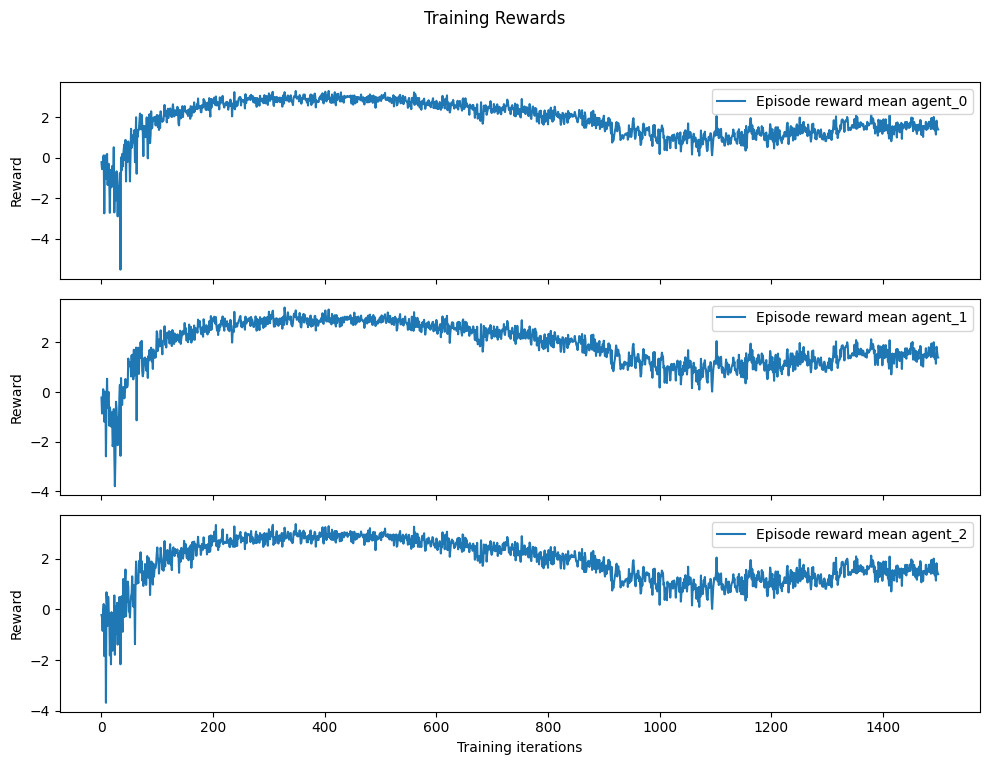

In [9]:
fig, axs = plt.subplots(n_agents, 1, figsize=(10, 8), sharex=True)
if n_agents == 1:
    axs = [axs]
for i, group in enumerate(env.group_map.keys()):
    axs[i].plot(episode_reward_mean_map[group], label=f"Episode reward mean {group}")
    axs[i].set_ylabel("Reward")
    axs[i].legend()
axs[-1].set_xlabel("Training iterations")
fig.suptitle("Training Rewards")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##Evaluation and Rendering

In [10]:
print("Starting evaluation and rendering...")

# Create a single environment for rendering
render_env = VmasEnv(
    scenario=scenario_name,
    num_envs=1,
    continuous_actions=True,
    max_steps=max_steps,
    device=device,
    n_agents=n_agents,
    group_map=custom_group_map,
)

td = render_env.reset()
frames = []

# Rollout Loop
with torch.no_grad():
    for _ in range(max_steps):
        # 1. Run policies to get actions
        for group in render_env.group_map.keys():
            td = policies[group](td)

        # 2. Step the environment
        td_next = render_env.step(td)

        # 3. Use the new observation for the next policy call
        td = td_next.get("next").clone()

        # 4. Reset if the episode terminated
        if td_next.get("done").item():
            td = render_env.reset()

        # 5. Render the frame and append to list
        frame = render_env.render(mode="rgb_array")
        frames.append(Image.fromarray(frame))

# Save the rollout as a GIF
gif_path = f"{scenario_name}_evaluation.gif"
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
)
print(f"✅ Saved animation as {gif_path}")

# To display the GIF in a Jupyter notebook, you can use the following:
# from IPython.display import Image as IPImage
# IPImage(filename=gif_path)

Starting evaluation and rendering...
✅ Saved animation as navigation_evaluation.gif


## Part 4

Based on your understanding of the differences between MADDPG and IDDPG, modify the necessary sections of your MADDPG implementation to convert it into its independent variant (IDDPG). Run the modified code, clearly explain the changes you made and the rationale behind each modification, and finally analyze and discuss the differences you observe between the performance of MADDPG and IDDPG.

## Answer:
In MADDPG, the critic looks at all agents observations and actions together. To make it IDDPG, I change the critic so that each agent only uses its own observation and action. This means the critic is no longer centralized and doesn’t need information from the other agents. I also adjust the input setup so it only concatenates the local state and action of the current agent.

Another change is in how I compute target actions. In MADDPG, I calculate target actions for all agents, since the centralized critic depends on them. In IDDPG, I only compute the target action for the current agent. With these changes, each agent learns on its own. This makes the method simpler, but agents may not coordinate as well as in MADDPG.

In [11]:
# Part 1: Actor definition (same as MADDPG)
policy_modules = {}
for group, agents in env.group_map.items():
    agent_modules = {}
    for agent in agents:
        observation_dim = env.observation_spec[(agent, "observation")].shape[-1]
        action_dim = env.full_action_spec[(agent, "action")].shape[-1]
        agent_modules[agent] = MLP(
            in_features=observation_dim,
            out_features=action_dim,
            num_cells=[256, 256],
            activation_class=nn.ReLU,
        )

    agent_policy_modules = {}
    for agent in agents:
        agent_policy_modules[agent] = TensorDictModule(
            agent_modules[agent],
            in_keys=[(agent, "observation")],
            out_keys=[(agent, "param")],
        )
    policy_modules[group] = TensorDictSequential(*agent_policy_modules.values())

### Probabilistic Policies

In [12]:
policies = {}
for group, agents in env.group_map.items():
    agent_policies = []
    for agent in agents:
        agent_policies.append(
            ProbabilisticActor(
                module=policy_modules[group],
                spec=env.full_action_spec[agent, "action"],
                in_keys=[(agent, "param")],
                out_keys=[(agent, "action")],
                distribution_class=TanhDelta,
                distribution_kwargs={
                    "low": env.full_action_spec_unbatched[agent, "action"].space.low,
                    "high": env.full_action_spec_unbatched[agent, "action"].space.high,
                },
                return_log_prob=False,
            )
        )
    policies[group] = TensorDictSequential(*agent_policies)

## Targets + exploration

In [13]:
target_policies = copy.deepcopy(policies)
exploration_policies = {}
for group, _agents in env.group_map.items():
    first_actor = None
    for module in policies[group].modules():
        if isinstance(module, ProbabilisticActor):
            first_actor = module
            break
    if first_actor is None:
        raise RuntimeError("No ProbabilisticActor found")

    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=first_actor.spec,
            annealing_num_steps=total_frames // 3,
            action_key=(group, "action"),
            sigma_init=0.5,
            sigma_end=0.05,
        ),
    )
    exploration_policies[group] = exploration_policy


Decentralized Critic (IDDPG)

In [14]:
critics = {}
for group, agents in env.group_map.items():
    agent_critic_modules = {}
    for agent in agents:
        critic_in_features = (
            env.observation_spec[(agent, "observation")].shape[-1]
            + env.full_action_spec[(agent, "action")].shape[-1]
        )
        agent_critic_modules[agent] = MLP(
            in_features=critic_in_features,
            out_features=1,
            num_cells=[256, 256],
            activation_class=nn.ReLU,
        )

    agent_critic_tdmodules = {}
    for agent in agents:
        cat_inputs = [(agent, "observation"), (agent, "action")]

        cat_module = TensorDictModule(
            module=lambda *xs: torch.cat(xs, dim=-1),
            in_keys=cat_inputs,
            out_keys=[(agent, "obs_actions")],
        )

        critic_module = TensorDictModule(
            agent_critic_modules[agent],
            in_keys=[(agent, "obs_actions")],
            out_keys=[(agent, "state_action_value")],
        )
        agent_critic_tdmodules[agent] = TensorDictSequential(cat_module, critic_module)

    critics[group] = TensorDictSequential(*agent_critic_tdmodules.values())

print("Model and policy structure ready for review.")

# Send to device
for group in env.group_map.keys():
    policies[group].to(device)
    target_policies[group].to(device)
    critics[group].to(device)
    exploration_policies[group].to(device)
    

Model and policy structure ready for review.


## Losses + Replay Buffer

In [15]:
shared_replay_buffer = ReplayBuffer(
    storage=LazyMemmapStorage(memory_size, scratch_dir=tempfile.TemporaryDirectory().name),
    sampler=RandomSampler(),
    batch_size=train_batch_size,
)
if device.type != "cpu":
    shared_replay_buffer.append_transform(lambda x: x.to(device))

losses = {}
for group, _agents in env.group_map.items():
    loss_module = DDPGLoss(
        actor_network=policies[group],
        value_network=critics[group],
        delay_value=True,
        delay_actor=True,
        loss_function="l2",
    )
    loss_module.set_keys(
        reward=(group, "reward"),
        done=(group, "done"),
        terminated=(group, "terminated"),
        state_action_value=(group, "state_action_value"),
    )
    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)
    losses[group] = loss_module

target_updaters = {group: SoftUpdate(loss, tau=polyak_tau) for group, loss in losses.items()}
optimisers = {
    group: {
        "loss_actor": torch.optim.Adam(loss.actor_network_params.flatten_keys().values(), lr=1e-4),
        "loss_value": torch.optim.Adam(loss.value_network_params.flatten_keys().values(), lr=3e-4),
    }
    for group, loss in losses.items()
}
print("Losses, optimizers, and replay buffer are ready.")


Losses, optimizers, and replay buffer are ready.


### Training loop (IDDPG change here)

In [16]:
collector = SyncDataCollector(
    env,
    TensorDictSequential(*exploration_policies.values()).to(device),
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

def process_batch(batch: TensorDictBase) -> TensorDictBase:
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        if ("next", group, "done") not in keys:
            batch.set(
                ("next", group, "done"),
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if ("next", group, "terminated") not in keys:
            batch.set(
                ("next", group, "terminated"),
                batch.get(("next", "terminated")).unsqueeze(-1).expand((*group_shape, 1)),
            )
    return batch

episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
pbar = tqdm(total=n_iters, desc="Training Progress")

for iteration, batch in enumerate(collector):
    current_frames = batch.numel()
    batch = process_batch(batch)
    shared_replay_buffer.extend(batch.reshape(-1))

    for group in env.group_map.keys():
        for _ in range(n_optimiser_steps):
            subdata = shared_replay_buffer.sample()
            if device.type != "cpu":
                subdata = subdata.to(device)

            # --- IDDPG difference: only current group ---
            with torch.no_grad():
                next_td = subdata["next"]
                target_out = target_policies[group](next_td)
                next_td.update(target_out)

            loss_vals = losses[group](subdata)
            for loss_name in ["loss_actor", "loss_value"]:
                loss = loss_vals[loss_name]
                optimiser = optimisers[group][loss_name]
                loss.backward()
                params = optimiser.param_groups[0]["params"]
                torch.nn.utils.clip_grad_norm_(params, max_grad_norm)
                optimiser.step()
                optimiser.zero_grad()
            target_updaters[group].step()
        exploration_policies[group][-1].step(current_frames)

    for group in env.group_map.keys():
        episode_reward_mean = (
            batch.get(("next", group, "episode_reward"))[batch.get(("next", group, "done"))]
            .mean()
            .item()
        )
        episode_reward_mean_map[group].append(episode_reward_mean)

    reward_strings = [f"{group}: {episode_reward_mean_map[group][-1]:.2f}" for group in env.group_map.keys()]
    pbar.set_description(f"Iter [{iteration+1}/{n_iters}] | Rewards: " + " | ".join(reward_strings))
    pbar.refresh()

pbar.close()
collector.shutdown()
print("\nTraining finished.")

Iter [1500/1500] | Rewards: agent_0: 1.18 | agent_1: 1.18 | agent_2: 1.18:   0%|          | 0/1500 [1:02:33<?, ?it/s]


Training finished.


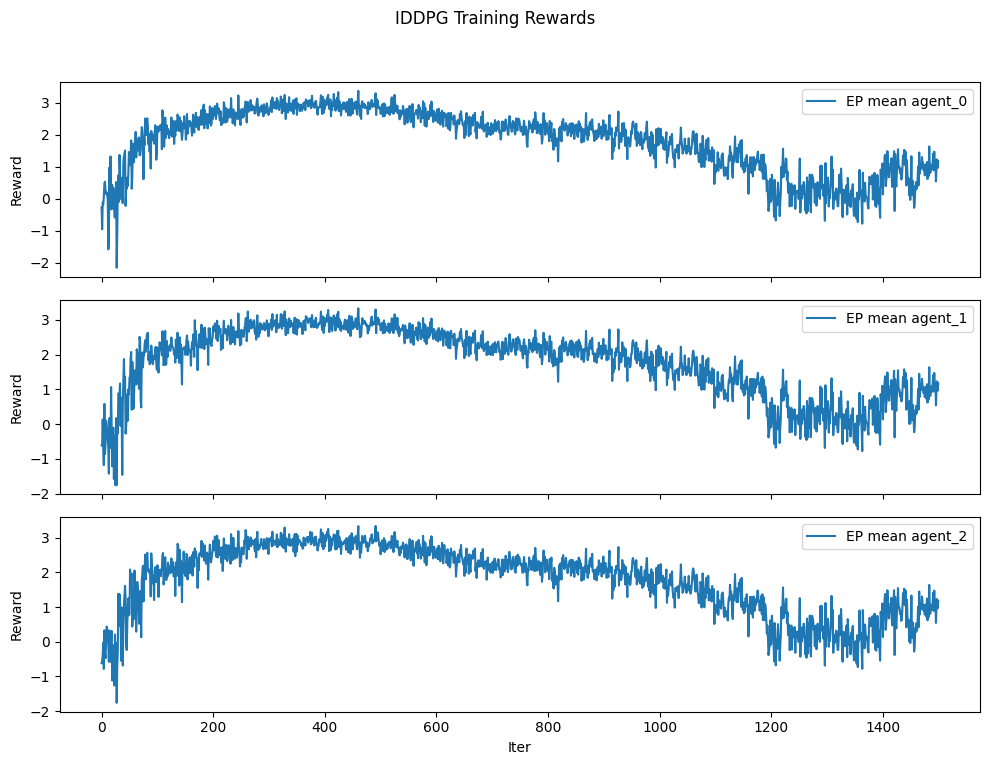

In [17]:
fig, axs = plt.subplots(n_agents, 1, figsize=(10, 8), sharex=True)
if n_agents == 1:
    axs = [axs]
for i, group in enumerate(env.group_map.keys()):
    axs[i].plot(episode_reward_mean_map[group], label=f"EP mean {group}")
    axs[i].set_ylabel("Reward")
    axs[i].legend()
axs[-1].set_xlabel("Iter")
fig.suptitle("IDDPG Training Rewards")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Analysis
In the IDDPG plots, each agent quickly improves at first, reaching good rewards around iteration 200–400. However, after that point their performance declines and becomes unstable, with noisy fluctuations and no clear long-term improvement. This shows that while independent learning works in the short run, the agents eventually interfere with each other, since each treats the changing policies of the others as part of the environment.

In contrast, MADDPG typically maintains more stable and higher performance. Because each critic in MADDPG has access to the actions of all agents during training, it can learn in a more stationary setting. This reduces the non-stationarity problem and leads to smoother convergence. In short: IDDPG agents improve fast but then destabilize due to non-stationarity, while MADDPG sustains stable learning and better overall results.